In [1]:
import torch
from custom_transformer import CustomTransformer

In [2]:
torch.manual_seed(1234)

In [3]:
# Testing on random input text before actual python scripts to make sure everything works.
with (open("../data/input.txt", "r") as file):
    text = file.read()

vocab = sorted(set(text))
print(len(vocab))

65


In [4]:
# ctoi = {ch : i for i, ch in enumerate(vocab)}
# itos = {i : ch for i, ch in enumerate(vocab)}

# encode = lambda s : [ctoi[c] for c in s]
# decode = lambda s : ''.join([itos[i] for i in s])

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# data = encode(text)
# train_size = int(len(data) * .9)
# train = data[:train_size]
# test = data[train_size:]

# def get_batches(dataset, batches, context_len):
#     pos = torch.randint(len(dataset) - context_len, (batches,))
#     x = torch.stack([torch.tensor(dataset[x : x + context_len], device=device) for x in pos])
#     y = torch.stack([torch.tensor(dataset[x + 1 : x + context_len + 1], device=device) for x in pos])

#     return x,y

In [6]:
# CONTEXT_LEN = 32
# BLOCK_COUNT = 1
# EMBED_DIM = 128
# HEAD_SIZE = 8
# LEARNING_RATE = 1e-2
# BATCH_COUNT = 32

# transformer = CustomTransformer(len(vocab), CONTEXT_LEN, EMBED_DIM, HEAD_SIZE, BLOCK_COUNT)
# optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)

In [7]:
# loss_history = []
# history = []
# loss_avg_block_size = 1
# for i in range(1):
#     train_in, train_target = get_batches(train, BATCH_COUNT, CONTEXT_LEN)

#     logits, loss = transformer(train_in, train_target)
#     print(logits.shape)
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()
#     optimizer.step()
    
#     history.append(loss.item())
#     if (i % loss_avg_block_size == 0):
#         print (f"Iteration {i} Loss: {history[-1]}")
#     if (len(history) >= loss_avg_block_size):
#         loss_history.append(torch.tensor(history).mean().item())
#         history = []

# if (len(history) > 0):
#     loss_history.append(torch.tensor(history).mean().item())
# print(loss_history[-1])

In [8]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.plot(range(1, len(loss_history * loss_avg_block_size) + 1, loss_avg_block_size), loss_history)
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.title('Loss History')
# plt.grid(True)
# plt.show()


In [9]:
# def complete(ctx, new_len):
#     res = [x for x in encode(ctx)]
#     for _ in range(new_len):
#         ctx = torch.tensor([res[-CONTEXT_LEN:]])
#         prob, loss = transformer(ctx, None) # Returns a tensor of size (1, W, EM)
#         prob = prob.squeeze(0)
#         prob = torch.softmax(prob, dim=-1) # (1, W, EM)
#         pred = torch.multinomial(prob, 1) # (1, W, 1)
#         res.append(pred[-1, 0].item())
#     return decode(res[-new_len:])

In [10]:
# start = 100
# sampled_txt = text[start:start+CONTEXT_LEN]
# print("_________________________SAMPLED_________________________:")
# print(sampled_txt)
# print("_________________________PREDICTED_______________________:")
# print(complete(sampled_txt, 16))

In [11]:
DELIMITER = "<END>"

In [12]:
import coDesc_parser

# Use first 50K * 10 for training, last, then 50K * 2 for testing
def load_examples(indices : list[int]):
    examples = coDesc_parser.load_examples(indices, "../data/CoDesc/fragmented")

    examples = [
        f"{DELIMITER}{x}{DELIMITER}" for x in examples
    ]

    return examples

# def get_batches(training_sample : bool):
#     training_texts = torch.randint(0, 50000 * 12, (100,)).tolist()

def get_batches(encoded_text, BATCH_COUNT, CONTEXT_LEN):
    pos = torch.randint(len(encoded_text) - CONTEXT_LEN, (BATCH_COUNT,))
#    print(pos)
    x = torch.stack([torch.tensor(encoded_text[x : x + CONTEXT_LEN], device=device) for x in pos])
    y = torch.stack([torch.tensor(encoded_text[x + 1 : x + CONTEXT_LEN + 1], device=device) for x in pos])

    return x,y

In [13]:
# import tiktoken

# coDesc_parser.large_text_file_dump(range(25000), "../data/CoDesc/fragmented", DELIMITER, "train.txt")
# coDesc_parser.large_text_file_dump(range(25000, 30000), "../data/CoDesc/fragmented", DELIMITER, "test.txt")
# #examples = load_examples(torch.randint(0, 50000 * 12, (100,)).tolist())

In [14]:
from tiktoken._educational import *

cl100k_base = tiktoken.get_encoding("cl100k_base")

with open("../data/CoDesc/fragmented/train.txt", "r") as f:
    train = f.read()

with open("../data/CoDesc/fragmented/test.txt", "r") as f:
    test = f.read()

train_enc = cl100k_base.encode(train)
test_enc = cl100k_base.encode(test)

In [15]:
CONTEXT_LEN = 512
BLOCK_COUNT = 1
EMBED_DIM = 256
NUM_HEADS = 8
LEARNING_RATE = 1e-2
BATCH_COUNT = 8
#print(cl100k_base.n_vocab)
transformer = CustomTransformer(cl100k_base.n_vocab, CONTEXT_LEN, EMBED_DIM, NUM_HEADS, BLOCK_COUNT)
optimizer = torch.optim.Adam(transformer.parameters(), lr=LEARNING_RATE)
print(sum(p.numel() for p in transformer.parameters()))


52099253


In [16]:
loss_history = []
history = []
loss_avg_block_size = 2

# Prefetch the first batch
#train_in, train_target = get_batches(train_enc, BATCH_COUNT, CONTEXT_LEN)

for i in range(10):
    def collate_fn(batch):
        return get_batches(*batch[0])
    # Use the prefetched batch
    current_train_in, current_train_target = get_batches(train_enc, BATCH_COUNT, CONTEXT_LEN)

    # Process the current batch
    logits, loss = transformer(current_train_in, current_train_target)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    history.append(loss.item())
    if (i % loss_avg_block_size == 0):
        print (f"Iteration {i} Loss: {history[-1]}")
    if (len(history) >= loss_avg_block_size):
        loss_history.append(torch.tensor(history).mean().item())
        history = []

if (len(history) > 0):
    loss_history.append(torch.tensor(history).mean().item())
#print(loss_history[-1])

Iteration 0 Loss: 11.79501724243164
Iteration 2 Loss: 8.352350234985352
Iteration 4 Loss: 9.550871849060059
Iteration 6 Loss: 9.208096504211426


KeyboardInterrupt: 

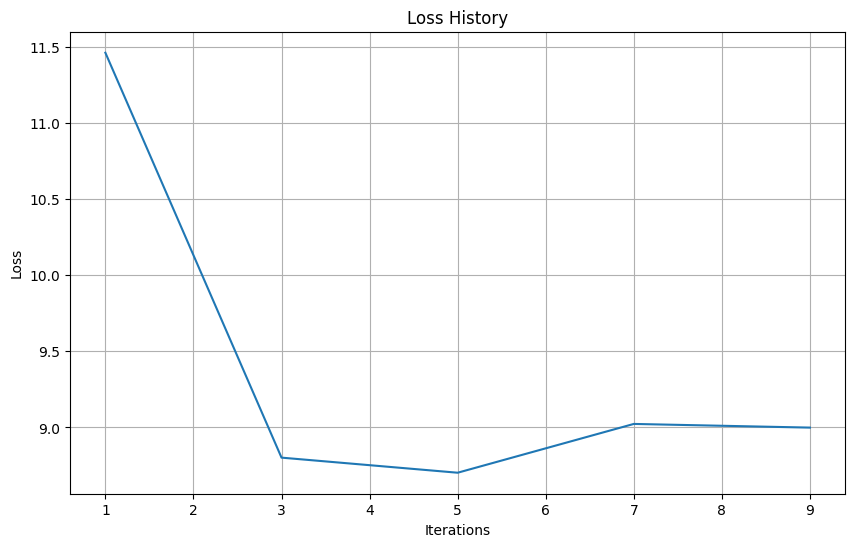

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(loss_history * loss_avg_block_size) + 1, loss_avg_block_size), loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss History')
plt.grid(True)
plt.show()


In [ ]:
def complete(ctx, new_len):
    res = [x for x in ctx]
    
    for _ in range(new_len):
        ctx = torch.tensor([res[-CONTEXT_LEN:]])
        prob, loss = transformer(ctx, None) # Returns a tensor of size (1, W, EM)
        prob = prob.squeeze(0)
        prob = torch.softmax(prob, dim=-1) # (1, W, EM)
        pred = torch.multinomial(prob, 1) # (1, W, 1)
        res.append(pred[-1, 0].item())
    return cl100k_base.decode(res[-new_len:])

In [ ]:
start = 679
sampled_txt = test_enc[start:start+CONTEXT_LEN]
print("_________________________SAMPLED_________________________:")
print(cl100k_base.decode(sampled_txt))
print("_________________________PREDICTED_______________________:")
print(complete(sampled_txt, 16))

_________________________SAMPLED_________________________:
<<<>DELIMITER<>>>
<<<>DELIMITER<>>>protected final int initConfiguration(){
		String propFile = this.optionPropFile.getValue();

		this.configuration = this.loadProperties(propFile);
		if(this.configuration==null){
			System.err.println(this.getAppName() + ": could not load configuration properties from file <" + propFile + ">, exiting");
			return -1;
		}

		if(this.configuration.get(PROP_RUN_SCRIPT_NAME)==null){
			System.err.println(this.getAppName() + ": configuration does not contain key <" + PROP_RUN_SCRIPT_NAME + ">, exiting");
			return -1;
		}
		if(this.configuration.get(PROP_RUN_CLASS)==null){
			System.err.println(this.getAppName() + ": configuration does not contain key <" + PROP_RUN_CLASS + ">, exiting");
			return -1;
		}
		if(this.configuration.get(PROP_JAVA_CP)==null){
			System.err.println(this.getAppName() + ": configuration
_________________________PREDICTED_______________________:
.class();
 String IllegalSt